# Исследование поведения пользователей в мобильном приложении "Ненужные вещи".

Цель исследования - классификация пользователей приложения по поведенческим признакам, нахождение различий в метриках для разных групп пользователей.

План действий:
1. Провести предобработку данных: скачать дата-сеты, проверить на пропуски и дубликаты, привести типы данных, дать понятные названия столбцам
2. Изучить состав столбцов: определить период, за который предоставлены данные, количество источников трафика, количество имен действий, выявить дубликаты в именах источников и действий
3. Подготовить таблицу к вычислению бизнес-показателей:
- собрать данные в одну таблицу, добавить столбцы для создания таблицы сессий
- отсортировать таблицу по имени пользователя и по времени события
- вычислить разницу во времени между текущим и предыдущим событием
- ввести переменную - временной интервал разделяющий сессии
- для каждого события установить номер сессии
- создать таблицу сессий
4. Retention Rate
- Рассчитать лайфтайм пользователя для каждой сессии.
- Построить таблицу удержания, то есть сводную таблицу, в которой названия строк — это даты первого посещения пользователей, названия столбцов — лайфтайм, а значения в «ячейках» — количество уникальных идентификаторов пользователей.
- Вычислить размеры когорт и занести результаты в отдельную таблицу.
- Объединить таблицы размеров когорт и удержания.
- Разделить каждую "ячейку" таблицы удержания на соответствующий размер когорты.
- Построить тепловую карту
- Построить кривые удержания по дням первого действия
5. Время проведенное в приложении
- построить гистограмму и ящик с усами для продолжительности сессий
- изучить аномалии, выявить типичную продолжительность сессии
- разделить пользователей по группам в зависимости от продолжительности сессий
6. Частота действий
- рассчитать количество действий пользователей в единицу времени в каждой сессии
- выявить аномалии и определить типичную частоту
7. Конверсия в целевое действие
- построить воронку продаж
- посчитать конверсию в целевое действие contacts_show
8. Сегментация пользователей - для пользователей с различной продолжительностью сессии посчитать Retention Rate и конверсию
9. Проверка гипотез статистическими тестами
- конверсии у пользователей, пришедших из yandex и google не отличаются
- конверсии у пользователей с разной продолжительностью сессий не отличаются
10. Выводы

## 1. Предобработка данных

In [1]:
import pandas as pd
import numpy as np 
import datetime as dt
from datetime import timedelta
from datetime import datetime

from matplotlib import pyplot as plt
plt.rcParams ['figure.figsize'] = [15, 6]
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import seaborn as sns
from scipy import stats as st
import math as mth

In [2]:
# загружаем датасеты
dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')

In [3]:
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [4]:
sources.info()
sources.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [5]:
# дадим имена столбцам в привычном стиле
dataset = dataset.rename(columns={'event.time':'event_time', 'event.name':'event_name', 'user.id':'user_id'})
sources = sources.rename(columns={'userId':'user_id'})

In [6]:
# приведем дату к правильному типу, округлим до целых секунд
dataset['event_time'] = pd.to_datetime(dataset['event_time']).dt.round('1s')

Итоги:
- данные получены в виде двух таблиц dataset и sources
- пропуски отсутствуют
- типы данных приведены
- дубликтов нет, но после округления времени появились, не удалены
- столбцы переименованы

## 2. Исследование данных

In [7]:
first_date = dataset['event_time'].min()
last_date = dataset['event_time'].max()

print('начало периода наблюдения', first_date)
print('конец периода наблюдения', last_date)
last_date - first_date

начало периода наблюдения 2019-10-07 00:00:00
конец периода наблюдения 2019-11-03 23:58:13


Timedelta('27 days 23:58:13')

мы имеем период 28 дней, 4 недели, менее одного осеннего месяца

In [8]:
# посмотрим сколько источников трафика и как распределены по ним пользователи
sources.groupby('source', as_index=False).agg({'user_id':'nunique'}).rename(columns={'user_id':'user_cnt'})

,source,user_cnt
0,google,1129
1,other,1230
2,yandex,1934


в каждом источнике достаточно пользователей для проведения сравнения

In [9]:
# посмотрим сколько типов действий и какое количество каждого действия
dataset.groupby('event_name', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'event_cnt'})

,event_name,event_cnt
0,advert_open,6164
1,contacts_call,541
2,contacts_show,4450
3,favorites_add,1417
4,map,3881
5,photos_show,10012
6,search_1,3506
7,search_2,324
8,search_3,522
9,search_4,701


In [10]:
# приведем однотипные события к одному имени
dataset['event_name'] = dataset['event_name'].replace('show_contacts', 'contacts_show')

dataset['event_name'] = dataset['event_name'].replace('search_1', 'search')
dataset['event_name'] = dataset['event_name'].replace('search_2', 'search')
dataset['event_name'] = dataset['event_name'].replace('search_3', 'search')
dataset['event_name'] = dataset['event_name'].replace('search_4', 'search')
dataset['event_name'] = dataset['event_name'].replace('search_5', 'search')
dataset['event_name'] = dataset['event_name'].replace('search_6', 'search')
dataset['event_name'] = dataset['event_name'].replace('search_7', 'search')

Итоги:
- период наблюдения - менее одного месяца
- 3 источника трафика, распределение данных по источникам позволяет проводить сравнительный анализ
- 16 наименований событий приведены к 9

## 3. Подготовка таблицы к вычислению бизнес-показателей

Соберем данные в одну таблицу, объединим по номеру пользователя, проверим перед этим уникальность пользователей в таблицах и возможные пересечения.

In [11]:
# проверка количества уникальных пользователей
print('количество уникальных пользователей в таблице событий', dataset['user_id'].nunique())
print('количество записей в таблице источников', len(sources))
print('количество уникальных пользователей в таблице источников', sources['user_id'].nunique())

количество уникальных пользователей в таблице событий 4293
количество записей в таблице источников 4293
количество уникальных пользователей в таблице источников 4293


In [12]:
# объединим таблицу событий и источники первого посещения
data = dataset.merge(sources, on='user_id', how='inner')

In [13]:
# сортируем таблицу по имени пользователя и времени события
data = data.sort_values(by=['user_id', 'event_time'], ignore_index = True)

In [14]:
data.head()

,event_time,event_name,user_id,source
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other


In [15]:
# импортируем таблицу для дашборда
data.to_csv('C:\yandex_pract\data_things.csv', index=False)

In [16]:
# создадим столбец со временем UNIX TIME
data['event_unix_time'] = (data['event_time'] - dt.datetime(1970, 1, 1)).dt.total_seconds()
data.head()

,event_time,event_name,user_id,source,event_unix_time
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09


In [17]:
# добавим столбец - разница во времени между предыдущим и текущим временем в секундах
data['diff_event_seconds'] = data.groupby('user_id')['event_unix_time'].diff()

In [18]:
data.head()

,event_time,event_name,user_id,source,event_unix_time,diff_event_seconds
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09,NaN
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09,45.0
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09,35.0
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09,135.0
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09,130.0


Для разделения действий на сессии требуется определить максимальный интервал между действиями относящимися к одной сессии пользователя. Будем считать, что большинство пользователей производят серии осмысленных действий, тогда большинство действий в датасете принадлежит к сессиям, таким образом и большинство интервалов тоже находится внутри сессий. Тогда для определения максимального интервала внутри сессии можно опираться на распределение интервалов в датасете.

In [19]:
# посмотрим как распределены интервалы
data['diff_event_seconds'].describe()

count    6.990400e+04
mean     1.398117e+04
std      9.197726e+04
min      0.000000e+00
25%      2.400000e+01
50%      7.100000e+01
75%      1.800000e+02
max      2.296195e+06
Name: diff_event_seconds, dtype: float64

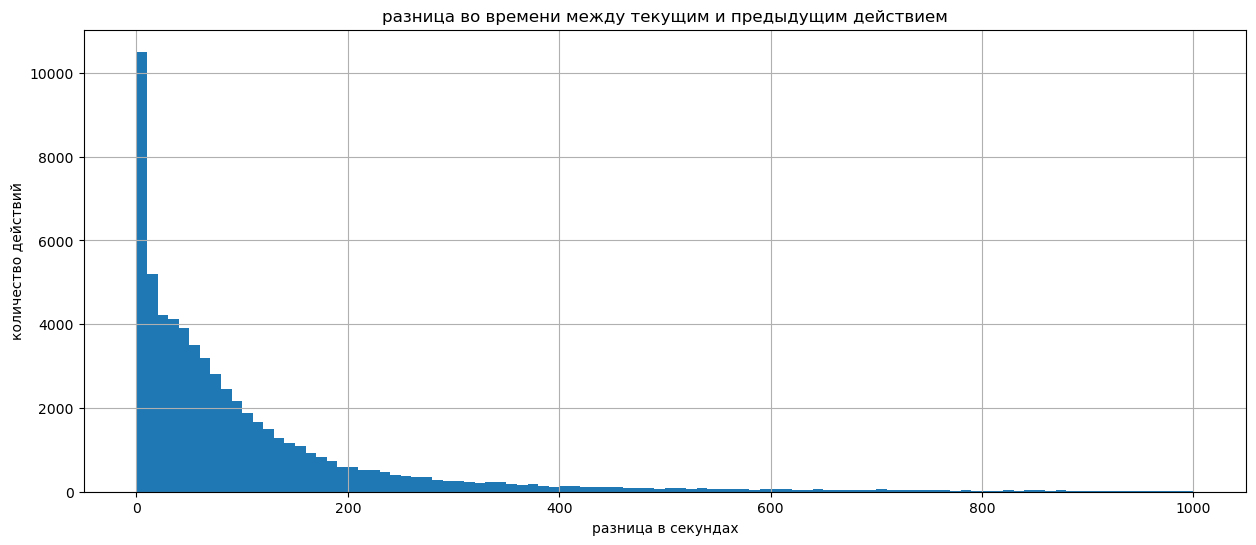

In [20]:
# построим гистограмму разниц во времени между событиями
data[data['diff_event_seconds'] <= 1000]['diff_event_seconds'].hist(bins=100)
plt.title('разница во времени между текущим и предыдущим действием')
plt.xlabel('разница в секундах')
plt.ylabel('количество действий')
plt.show()

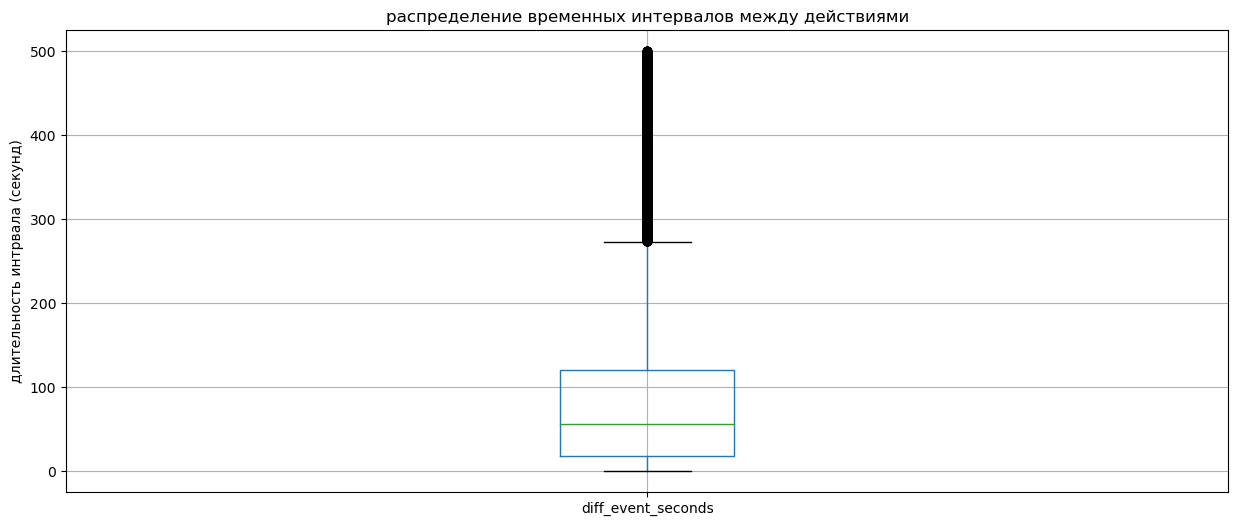

In [21]:
# построим ящик с усами - количество сессий по продолжительности сессии
data[data['diff_event_seconds'] <= 500].boxplot(column='diff_event_seconds')
plt.title('распределение временных интервалов между действиями')
plt.ylabel('длительность интрвала (секунд)')
plt.show()

Максимальный интервал следует взять от 75 квантиля (сессий будет больше), до 95 квантиля (в этом случае максимальное количество действий объединится в длиные сессии, только аномальные выбросы станут интервалами между сессиями). Так как делать перерывы в работе с приложением мы не считаем аномальным поведением, следует устанавливать максимальный интервал в сессиях ниже уровня 95 квантиля.

In [22]:
print('квантиль 84%', round(data['diff_event_seconds'].quantile(.84) / 60, 1), 'минут')
print('квантиль 85%', round(data['diff_event_seconds'].quantile(.85) / 60, 1), 'минут')
print('квантиль 86%', round(data['diff_event_seconds'].quantile(.86) / 60, 1), 'минут')
print('квантиль 87%', round(data['diff_event_seconds'].quantile(.87) / 60, 1), 'минут')
print('квантиль 88%', round(data['diff_event_seconds'].quantile(.88) / 60, 1), 'минут')
print('квантиль 89%', round(data['diff_event_seconds'].quantile(.89) / 60, 1), 'минут')
print('квантиль 90%', round(data['diff_event_seconds'].quantile(.90) / 60, 1), 'минут')
print('квантиль 91%', round(data['diff_event_seconds'].quantile(.91) / 60, 1), 'минут')

квантиль 84% 5.6 минут
квантиль 85% 6.2 минут
квантиль 86% 7.1 минут
квантиль 87% 8.4 минут
квантиль 88% 10.0 минут
квантиль 89% 12.6 минут
квантиль 90% 17.0 минут
квантиль 91% 25.7 минут


Установим максимальный интервал 10 минут, что соответствует квантилю 88%

In [23]:
# добавляем переменную: период между сессиями 10 минут = 600 секунд
time_delta = 600

Разобьем все посещения по сессиям: добавим столбец с номером сессии для каждого пользователя

In [24]:
# создаем объект Series с флагами начала новой сессии True/False
new_session = (data['diff_event_seconds'].isnull()) | (data['diff_event_seconds'] > time_delta)

# добавляем столбец: для каждого пользователя ранжируем новые сессии
data['session_id'] = data.loc[new_session, ['user_id', 'event_unix_time']].groupby('user_id').rank(method='first')

# заполняем пропуски в новом столбце предыдущим значением - номером сессии
data['session_id'] = data['session_id'].fillna(method='ffill').astype(int)
# заполняем нулями пропуски в столбце времени - время первых событий каждого пользователя
data['diff_event_seconds'] = data['diff_event_seconds'].fillna(0).astype(int)
# обнулим разницу во времени для каждой новой сессии
data['diff_event_seconds'] = data['diff_event_seconds'] * (1 - new_session)

data.head()

,event_time,event_name,user_id,source,event_unix_time,diff_event_seconds,session_id
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09,0,1
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09,45,1
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09,35,1
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09,135,1
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.570456e+09,130,1


In [25]:
# добавим столбцы с датой в формате даты, номером дня недели, названием дня недели
data['event_date'] = data['event_time'].dt.date
data['weekday_number'] = data['event_time'].dt.weekday
data['weekday_name'] = data['event_time'].dt.day_name()

Создадим таблицу сессий - сгруппируем данные по номеру пользователя и номеру сессии. Укажем источник, время и дату начала сессии, продолжительность сессии 

In [26]:
sessions = data.groupby(by=['user_id', 'session_id', 'source'], as_index=False).agg({'event_time':'min', 'event_name':'first', 'diff_event_seconds': 'sum'})

# дадим столбцам актуальные названия
sessions = sessions.rename(columns={'event_time':'session_start', 'event_name':'first_event_name', 'diff_event_seconds':'session_seconds'})
sessions.head()

,user_id,session_id,source,session_start,first_event_name,session_seconds
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,other,2019-10-07 13:39:46,tips_show,596
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,other,2019-10-09 18:33:56,map,507
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,other,2019-10-21 19:52:31,tips_show,899
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,other,2019-10-22 11:18:15,map,758
4,00157779-810c-4498-9e05-a1e9e3cedf93,1,yandex,2019-10-19 21:34:34,search,739


Итоги:
- в таблицу data собрали все сырые данные, отсортировали, разбили по сессиям, нашли разницу во времени между текущим и предыдущим событием каждой сессии
- создали таблицу sessions, содержащую номер пользователя, источник, начало сессии и продолжительность в секундах

## 4. Retention rate

In [27]:
# найдем для каждого пользователя дату первого посещения
users_start = sessions.groupby('user_id', as_index=False).agg({'session_start':'min'})
users_start = users_start.rename(columns={'session_start': 'first_event'})

# добавим к таблице сессий к каждой сессии дату первого посещения
sessions = sessions.merge(users_start, on='user_id', how='inner')

In [28]:
# добавляем столбец - дата первого посещения округленная вниз до дня
sessions['first_date'] = pd.to_datetime(sessions['first_event']).dt.floor('1D')
# добавляем столбец лайфтаймов
sessions['lifetime'] = (sessions['session_start'] - sessions['first_event']).dt.days.astype('int')

In [29]:
sessions.head()

,user_id,session_id,source,session_start,first_event_name,session_seconds,first_event,first_date,lifetime
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,other,2019-10-07 13:39:46,tips_show,596,2019-10-07 13:39:46,2019-10-07,0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,other,2019-10-09 18:33:56,map,507,2019-10-07 13:39:46,2019-10-07,2
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,other,2019-10-21 19:52:31,tips_show,899,2019-10-07 13:39:46,2019-10-07,14
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,other,2019-10-22 11:18:15,map,758,2019-10-07 13:39:46,2019-10-07,14
4,00157779-810c-4498-9e05-a1e9e3cedf93,1,yandex,2019-10-19 21:34:34,search,739,2019-10-19 21:34:34,2019-10-19,0


In [30]:
# функция получения таблицы удержания из таблицы сессий с учетом горизонта и момента наблюдения
def get_retention(sessions, observation_date, horizon_days, dimensions, ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    sessions = sessions.query('first_date <= @last_suitable_acquisition_date')

    # рассчитываем удержание
    retention_table = sessions.pivot_table(
        index=dimensions, columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        sessions.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    retention_table = cohort_sizes.merge(
        retention_table, on=dimensions, how='left'
    ).fillna(0)
    retention_table = retention_table.div(retention_table['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    retention_table = retention_table[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    retention_table['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания
    return retention_table

In [31]:
# установим момент анализа - окончание наблюдения
observation_date = data['event_time'].max().date()
# установим горизонт анализа - 14 дней
horizon_days = 14
# разбивка когорт по дате первого визита
dimensions = ['first_date']
# вызовем функцию для получения таблицы коэффициентов удержания
retention = get_retention(sessions, observation_date, horizon_days, dimensions, ignore_horizon=False)

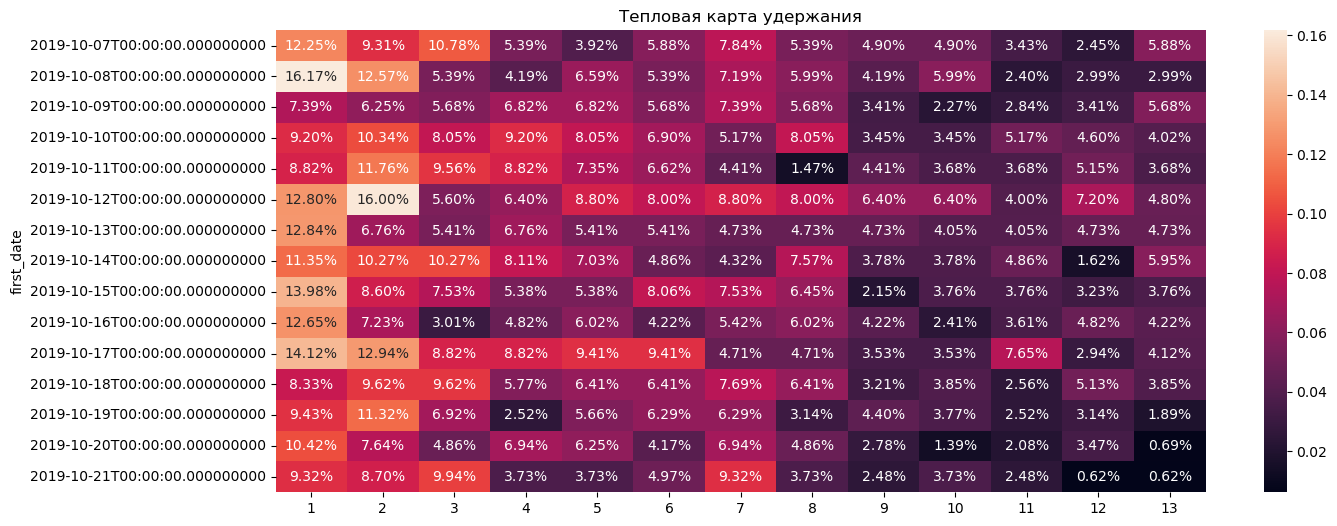

In [32]:
plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    retention.drop(columns=['cohort_size', 0]),  # удаляем размеры когорт
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика

plt.show()

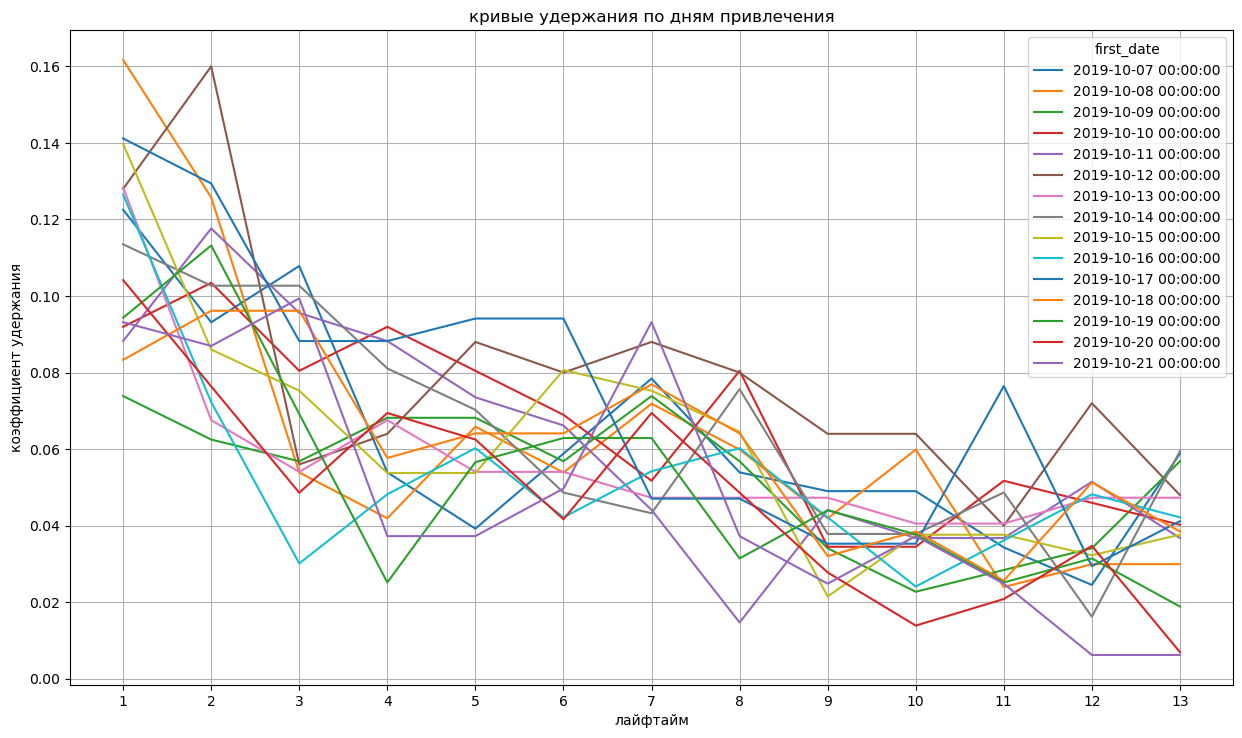

In [33]:
# удаление столбца cohort_size и транспонирование (переворачивание) таблицы
# с помощью атрибута T: столбцы становятся строками, а строки - столбцами
report = retention.drop(columns = ['cohort_size']).T

# строим кривые удержания
report = retention.drop(columns = ['cohort_size', 0])

report.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(report.columns.values),  # отметки на оси X — названия колонок
    figsize=(15, 8.5),  # размер графика
)
plt.xlabel('лайфтайм')  # название оси X
plt.ylabel('коэффициент удержания') # название оси Y
plt.title('кривые удержания по дням привлечения')  # название графика

plt.show()

Итоги:
- самая большая часть пользователей теряется в первый день, коэффициент удержания на второй день не превышает 16,7%
- падение числа активных пользователей неравномерное, пользователи часто возвращаются, не пользуются приложением ежедневно
- наилучшие коэффициенты удержания демонстрируют когорты с 12 по 17 октября

## 5. Время проведенное в приложении

In [34]:
# посмотрим как распределены продолжительности сессий с помощью describe
sessions['session_seconds'].describe()

count    12689.000000
mean       448.646229
std        699.109387
min          0.000000
25%          0.000000
50%        201.000000
75%        608.000000
max      11544.000000
Name: session_seconds, dtype: float64

In [35]:
print('медианное время сессии', round(sessions['session_seconds'].median() / 60), 'минут')
print('95% сессий менее чем', round(sessions['session_seconds'].quantile(.95) / 60), 'минут')

медианное время сессии 3 минут
95% сессий менее чем 29 минут


In [36]:
# будем считать аномально долгими сессии более 95-го квантиля, аномально малой сессией - 0 секунд (одно действие)
max_session = sessions['session_seconds'].quantile (.95)
min_session = 0

In [37]:
print('количество сессий больше', round(max_session / 60), 'минут =', len(sessions[sessions['session_seconds'] > max_session]))

количество сессий больше 29 минут = 634


In [38]:
print('количество сессий с нулевым времением, т.е. одним действием =', len(sessions[sessions['session_seconds'] == 0]))
print('доля сессий с нулевым временем =', round((len(sessions[sessions['session_seconds'] <= min_session]) / len(sessions))*100, 2),'%' )

количество сессий с нулевым времением, т.е. одним действием = 3252
доля сессий с нулевым временем = 25.63 %


Построим гистограмму сессий с убранными аномалиями (нулевые сессии состоящие из одного действия и аномально долгие)

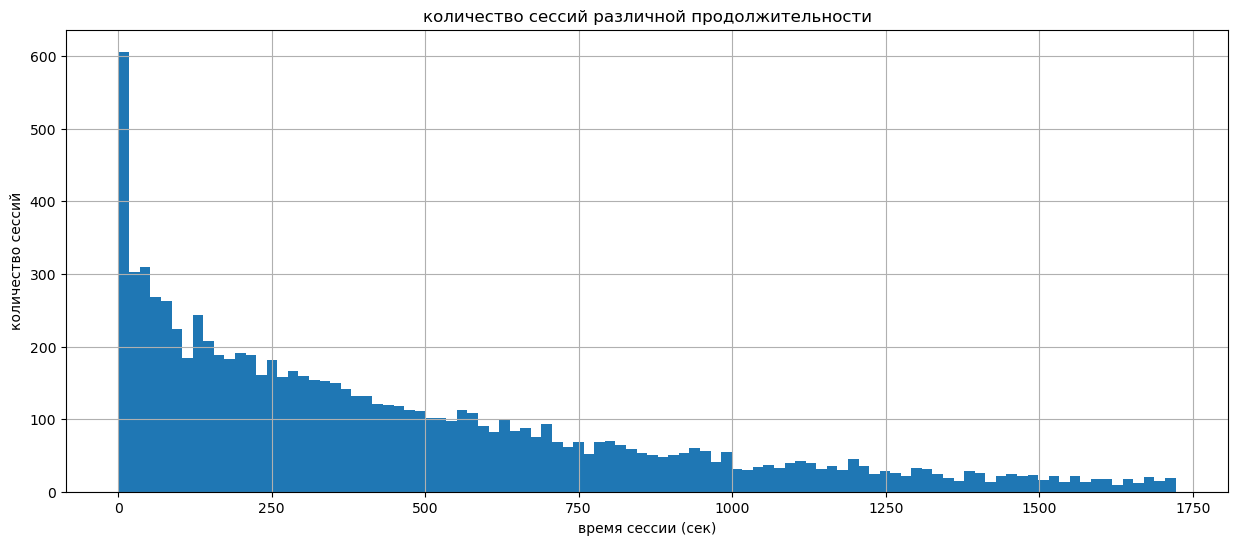

In [39]:
sessions[(sessions['session_seconds'] > min_session) & (sessions['session_seconds'] <= max_session)]['session_seconds'].hist(bins=100)
plt.title('количество сессий различной продолжительности')
plt.xlabel('время сессии (сек)')
plt.ylabel('количество сессий')
plt.show()

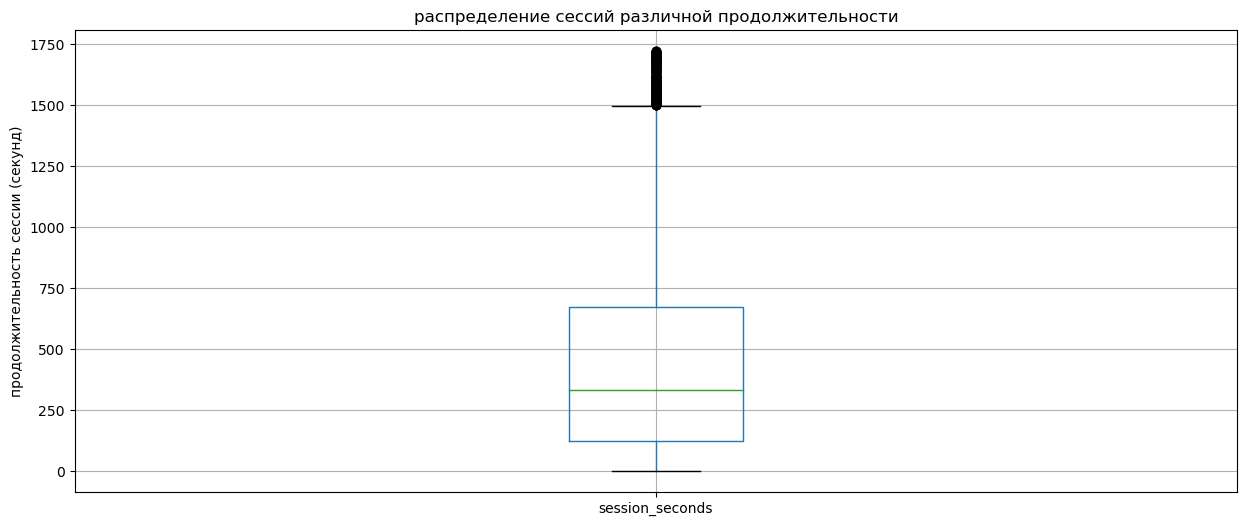

In [40]:
# построим ящик с усами - количество сессий по продолжительности сессии
sessions[(sessions['session_seconds'] > min_session) & (sessions['session_seconds'] <= max_session)].boxplot(column='session_seconds')
plt.title('распределение сессий различной продолжительности')
plt.ylabel('продолжительность сессии (секунд)')
plt.show()

Выделим группу пользователей отличающихся продолжительностью сессий, у которых медианная длина сессии превышает длину 75% сессий

In [41]:
# будем считать длинными сессии более 3-го перцентиля
long_session = round(sessions['session_seconds'].quantile(.75))
print('длинными будем считать сессии более 3-го перцентиля =', round(sessions['session_seconds'].quantile(.75) / 60), 'минут')

длинными будем считать сессии более 3-го перцентиля = 10 минут


In [42]:
# группируем по пользователю и находим медиану продолжительности сессий
sessions_by_user = sessions.groupby('user_id', as_index=False).agg({'session_seconds':'median'}).rename(columns={'session_seconds':'session_median'})

# добавим столбец с флагом - пользователь с длинными сессиями
sessions_by_user['long_sessions'] = np.where(sessions_by_user['session_median'] > sessions['session_seconds'].quantile(.75), 'long_time', 'usual_time')
sessions_by_user.head()

,user_id,session_median,long_sessions
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,677.0,long_time
1,00157779-810c-4498-9e05-a1e9e3cedf93,597.5,usual_time
2,00463033-5717-4bf1-91b4-09183923b9df,1483.0,long_time
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,149.0,usual_time
4,00551e79-152e-4441-9cf7-565d7eb04090,4.0,usual_time


In [43]:
print('количество пользователей с долгими сессиями:', len(sessions_by_user[sessions_by_user['long_sessions'] == 'long_time']))
print('доля пользователей с долгими сессиями:', round(len(sessions_by_user[sessions_by_user['long_sessions'] == 'long_time']) / data['user_id'].nunique(), 2))

количество пользователей с долгими сессиями: 1211
доля пользователей с долгими сессиями: 0.28


Посмотрим, как распределены действия в сессиях с нулевым временем. Причины появления таких сессий:
- открытие приложения на странице tips_show, закрытие приложения - самый ожидаемый сценарий 
- открытие приложения на другой странице, нажатие одной кнопки, закрытие приложения

In [44]:
sessions[sessions['session_seconds'] == 0].groupby('first_event_name', as_index=False).agg({'user_id':'count'})

,first_event_name,user_id
0,advert_open,65
1,contacts_show,214
2,favorites_add,54
3,map,151
4,photos_show,804
5,search,517
6,tips_click,23
7,tips_show,1424


Итоги:
- четверть всех сессий имеет нулевую продолжительность, т.е. одно действие
- в сессиях с нулевой продолжительностью присутствуют все действия кроме contacts_call
- большинство сессий имеет продолжительность от 2 до 10 минут
- мы выделили группу пользователей, имеющих долгие сессии (медиана их сессий больше 10 минут)

## 6. Частота действий

Посчитаем количество действий в сессию

In [45]:
# для каждой сессии посчитаем отношение количества действий ко времени сессии
frequency = data.groupby(['user_id','session_id'], as_index=False).agg({'source':'first', 'diff_event_seconds':'sum', 'event_name':'count'})
frequency = frequency.rename(columns={'diff_event_seconds':'total_seconds', 'event_name':'total_events'})

# убираем сессии с нулевым временем (одним событием), чтобы исключить деление на 0 и бесконечную частоту
frequency = frequency[frequency['total_seconds'] != 0]

# добавляем столбец с частотой - количество действий в минуту
frequency['events_per_minute'] = frequency['total_events'] / (frequency['total_seconds'] / 60)

frequency['events_per_minute'].describe()

count    9437.000000
mean        3.355404
std        12.780594
min         0.151134
25%         0.537313
50%         0.874439
75%         1.714286
max       480.000000
Name: events_per_minute, dtype: float64

In [46]:
print('95% сессий имеет количество действий в минуту не более', frequency['events_per_minute'].quantile (.95))

95% сессий имеет количество действий в минуту не более 11.45054945054933


In [47]:
# установим аномальную частоту действий в минуту - 95 квантиль
max_frequency = frequency['events_per_minute'].quantile (.95)

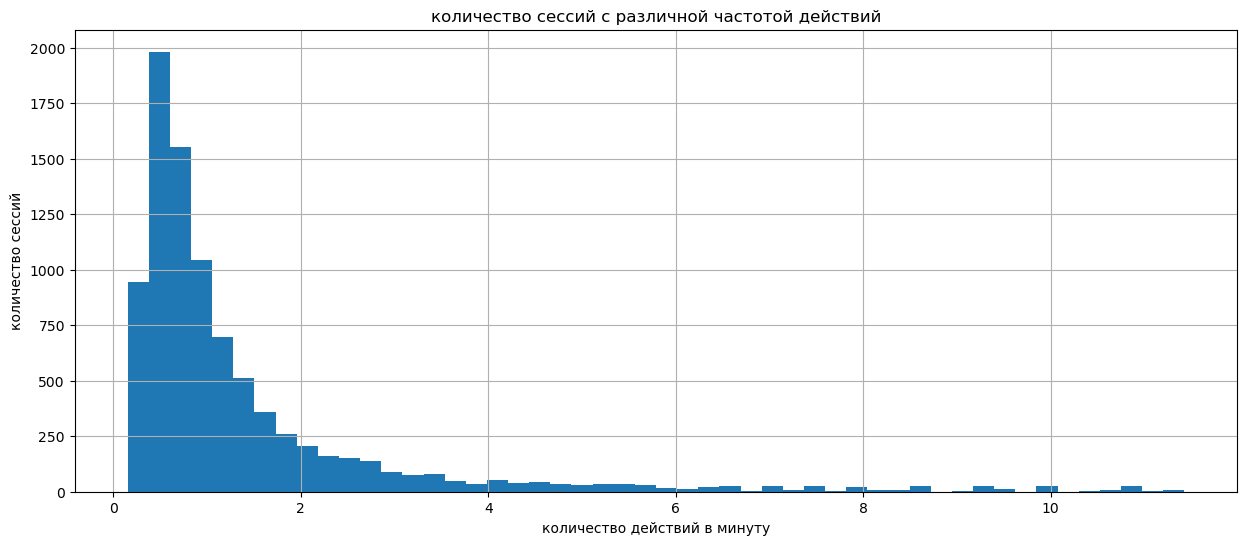

In [48]:
# построим гистограмму количества сессий по частоте событий без аномалий
frequency[frequency['events_per_minute'] < max_frequency]['events_per_minute'].hist(bins=50)
plt.title('количество сессий с различной частотой действий')
plt.xlabel('количество действий в минуту')
plt.ylabel('количество сессий')
plt.show()

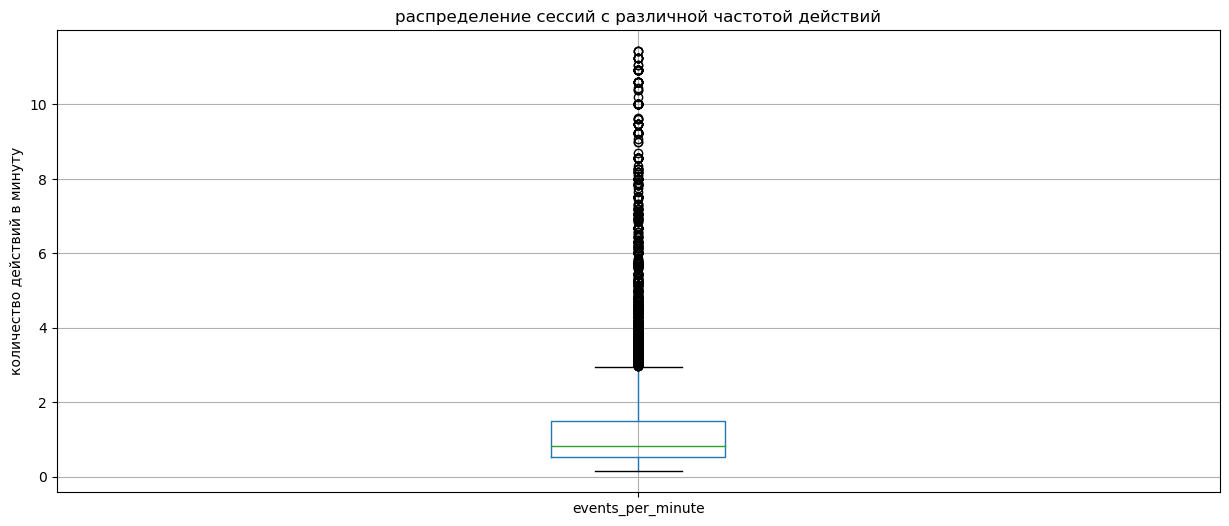

In [49]:
# построим ящик с усами - количество сессий по частоте событий
frequency[frequency['events_per_minute'] < max_frequency].boxplot(column='events_per_minute')
plt.title('распределение сессий с различной частотой действий')
plt.ylabel('количество действий в минуту')
plt.show()

In [50]:
sessions

,user_id,session_id,source,session_start,first_event_name,session_seconds,first_event,first_date,lifetime
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,other,2019-10-07 13:39:46,tips_show,596,2019-10-07 13:39:46,2019-10-07,0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,other,2019-10-09 18:33:56,map,507,2019-10-07 13:39:46,2019-10-07,2
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,other,2019-10-21 19:52:31,tips_show,899,2019-10-07 13:39:46,2019-10-07,14
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,other,2019-10-22 11:18:15,map,758,2019-10-07 13:39:46,2019-10-07,14
4,00157779-810c-4498-9e05-a1e9e3cedf93,1,yandex,2019-10-19 21:34:34,search,739,2019-10-19 21:34:34,2019-10-19,0
...,...,...,...,...,...,...,...,...,...
12684,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,37,google,2019-11-02 18:17:41,contacts_show,0,2019-10-12 00:57:21,2019-10-12,21
12685,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,38,google,2019-11-02 19:25:54,tips_show,296,2019-10-12 00:57:21,2019-10-12,21
12686,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,39,google,2019-11-03 14:32:56,tips_show,948,2019-10-12 00:57:21,2019-10-12,22
12687,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,40,google,2019-11-03 15:36:01,tips_show,957,2019-10-12 00:57:21,2019-10-12,22


Изучим активность пользователей в течение недели. Для этого добавим столбец - день недели, сгруппируем по дням и посчитаем количество действий. Период наблюдения составляет ровно 4 недели, поэтому можно использовать все данные.

In [51]:
# группируем действия по дням недели, группируем целевое действие по дням недели, объединяем таблицы
events_by_weekday = data.groupby('weekday_number', as_index=False).agg({'weekday_name':'first','user_id':'count'}).rename(columns={'user_id':'events'})
success_by_weekday = data[data['event_name'] == 'contacts_show'].groupby('weekday_number', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'contacts_show'})
conversion_by_weekday = events_by_weekday.merge(success_by_weekday, on='weekday_number')

# считаем отношение количества целевых действий к общему числу
conversion_by_weekday['conversion'] = conversion_by_weekday['contacts_show'] / conversion_by_weekday['events']
conversion_by_weekday

,weekday_number,weekday_name,events,contacts_show,conversion
0,0,Monday,11671,646,0.055351
1,1,Tuesday,11145,708,0.063526
2,2,Wednesday,10994,715,0.065035
3,3,Thursday,10763,825,0.076651
4,4,Friday,9969,665,0.066707
5,5,Saturday,9154,447,0.048831
6,6,Sunday,10501,523,0.049805


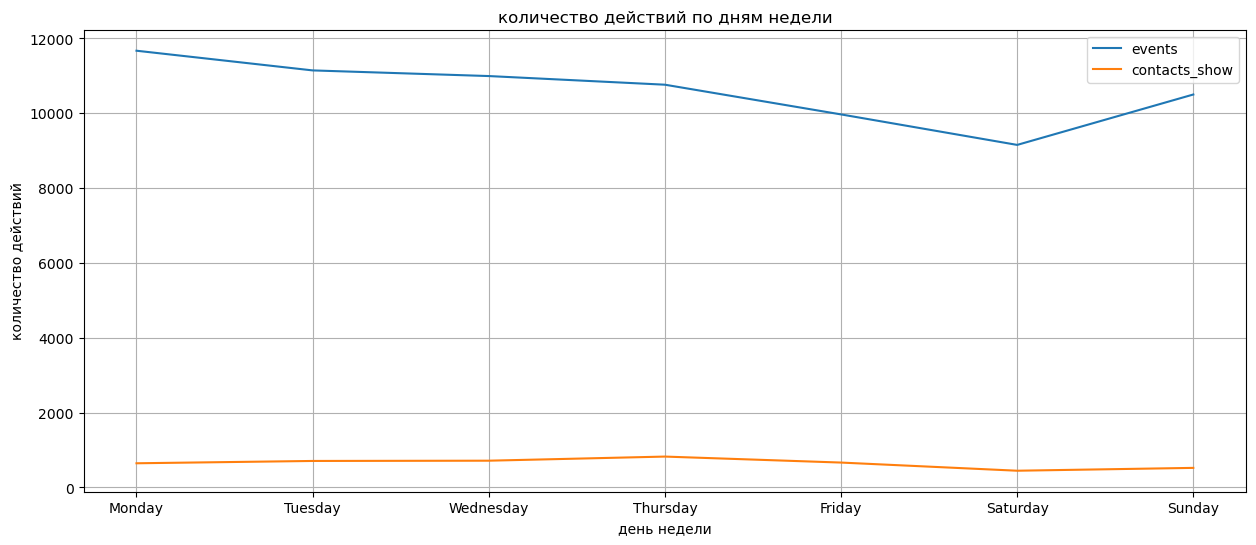

In [52]:
conversion_by_weekday[['events', 'contacts_show']].plot(grid=True)
plt.title('количество действий по дням недели')
plt.xlabel('день недели')
plt.ylabel('количество действий')
plt.xticks (ticks=conversion_by_weekday['weekday_number'].to_list(), labels=conversion_by_weekday['weekday_name'].to_list())
plt.show()

- количество действий максимально в понедельник и последовательно падает до субботы, в воскресенье возрастает почти до уровня четверга
- количество целевых действий наоборот растет с понедельника и достигает максимума в четверг, затем резко падает, худший показатель в субботу
- отношение целевых действий к общему количеству минимально в субботу, максимально в четверг

Итоги:
- в большинстве сессий частота не превышает 2 действия в минуту - это очень низкий показатель
- 95% сессий имеет частоту менее 12 действий в минуту
- активность пользователей максимальна со вторника по четверг
- суббота - наихудший день по количеству действий, целевых действий, доле целевых действий

## 7. Конверсия в целевое действие - просмотр контактов

In [53]:
# посчитаем для каждого события количество действий и уникальных пользователей
events = data.groupby('event_name', as_index=False).agg({'event_time': 'count', 'user_id': 'nunique'})

# дадим столбцам правильные имена
events = events.rename(columns={'event_time':'event_cnt', 'user_id':'user_cnt'})

# добавим столбец - доля пользователей совершивших действие
events['conversion'] = events['user_cnt'] / data['user_id'].nunique()

events

,event_name,event_cnt,user_cnt,conversion
0,advert_open,6164,751,0.174936
1,contacts_call,541,213,0.049616
2,contacts_show,4529,981,0.228512
3,favorites_add,1417,351,0.081761
4,map,3881,1456,0.339157
5,photos_show,10012,1095,0.255066
6,search,6784,1666,0.388074
7,tips_click,814,322,0.075006
8,tips_show,40055,2801,0.652457


In [54]:
# список дейсвтий, которые были в качестве первых действий у пользователей
first_event = data.groupby('user_id', as_index=False).agg({'event_name':'first'}).rename(columns={'event_name':'first_event'})
first_event = first_event.groupby('first_event', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'users_cnt'})
first_event

,first_event,users_cnt
0,advert_open,127
1,contacts_show,179
2,favorites_add,49
3,map,807
4,photos_show,560
5,search,1160
6,tips_click,13
7,tips_show,1398


Все действия кроме contacts_call могут быть первым действием пользователя, самое массовое действие в датасете tips_show совершили всего 65% пользователей. Воронку продаж для всего датасета, в которую последовательно вошли бы все действия, строить нет смысла, вместо этого можно рассматривать конверсии от одного действия к другому (например от contacts_show к contacts_call или от tips_show к tips_click) для изучения потерь на каждом варианте перехода. Далее мы рассмотрим самый общий случай - конверсию всех уникальных пользователей в целевое действие contacts_show для различных групп пользователей.

Итог:
- конверсия в целевое действие contacts_show составила 22,85%

Соберем вместе полученные результаты:
- самая большая часть пользователей теряется в первый день, коэффициент удержания на второй день не превышает 16,7%
- падение числа активных пользователей неравномерное, пользователи часто возвращаются, не пользуются приложением ежедневно
- на основе распределения интервалов во времени между действиями мы установили 10-ти минутный перерыв в использовании приложения как интервал между сессиями (последовательностями связанных действий)
- четверть всех сессий имеет нулевую продолжительность, т.е. одно действие (в списке присутствуют все действия кроме contacts_call)
- большинство сессий имеет продолжительность от 2 до 10 минут
- в большинстве сессий частота не превышает 2 действия в минуту
- 95% сессий имеет частоту менее 12 действий в минуту
- активность пользователей максимальна со вторника по четверг
- суббота - наихудший день по количеству действий, целевых действий, доле целевых действий
- конверсия в целевое действие contacts_show составила 22,85%

## 8. Сегментация пользователей

Большое количество пользователей уходит в первый день, много сессий состоит всего из одного действия, большинство сессий имеет небольшую продолжительность. Возможно, нашей целевой аудиторией являются пользователи с долгими сессиями, они проводят в приложении больше времени и совершают большее число целевых действий. Медианная продолжительность сессий этих пользователей выше, чем продолжительность 75% всех сессий, таких пользователей 28%. Проверим, лучше ли они удерживаются и имеют ли они лучшую конверсию.

### Retention Rate у пользователей с длинными сессиями.

In [55]:
# присоединим к таблице сессий информацию с флагом - "пользователь с длинными сессиями"
sessions = sessions.merge(sessions_by_user, on='user_id', how='inner')

Построим тепловую карту и кривые удержания по дням для пользователей с длинными и обычными сессиями

In [56]:
# установим момент анализа - окончание наблюдения
observation_date = data['event_time'].max().date()
# установим горизонт анализа - 14 дней
horizon_days = 14
# разбивка когорт по дате первого визита
dimensions = ['long_sessions']
# вызовем функцию для получения таблицы коэффициентов удержания
retention = get_retention(sessions, observation_date, horizon_days, dimensions, ignore_horizon=False)

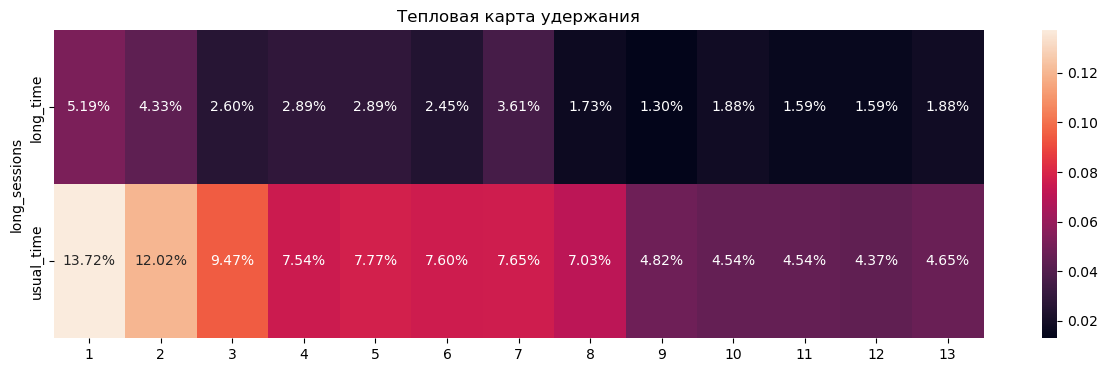

In [57]:
plt.figure(figsize=(15, 4))  # задаём размер графика
sns.heatmap(
    retention.drop(columns=['cohort_size', 0]),  # удаляем размеры когорт
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()

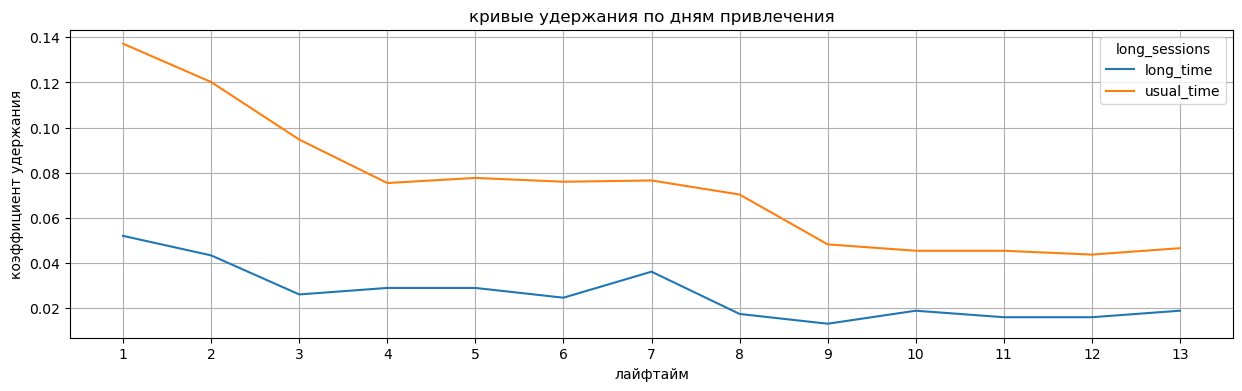

In [58]:
# удаление столбца cohort_size и транспонирование (переворачивание) таблицы
# с помощью атрибута T: столбцы становятся строками, а строки - столбцами
report = retention.drop(columns = ['cohort_size']).T

# строим кривые удержания
report = retention.drop(columns = ['cohort_size', 0])

report.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(report.columns.values),  # отметки на оси X — названия колонок
    figsize=(15, 4),  # размер графика
)
plt.xlabel('лайфтайм')  # название оси X
plt.ylabel('коэффициент удержания') # название оси Y
plt.title('кривые удержания по дням привлечения')  # название графика
plt.show()

Итог:
- пользователи с более длинными сессиями удерживаются хуже
- активный уход пользователей в первые 4-5 дней, затем несколько дней плато, 8-9 день вновь отток пользователей, затем плато

### Конверсия у пользователей с длинными сессиями.

In [59]:
# присоединим к таблице событий флаги "пользователи с длинными сессиями"
data = data.merge(sessions_by_user, on='user_id', how='inner')

In [60]:
# количество пользователей с длинными сессиями
users_long = data[data['long_sessions'] == 'long_time']['user_id'].nunique()
# количество пользователей с обычными сессиями
users_usual = data[data['long_sessions'] == 'usual_time']['user_id'].nunique()
# количество пользователей с длинными сессиями, совершивших целевое действие contacts_show
acted_long = data[(data['long_sessions'] == 'long_time') & (data['event_name'] == 'contacts_show')]['user_id'].nunique()
# количество пользователей с обычными сессиями, совершивших целевое действие contacts_show
acted_usual = data[(data['long_sessions'] == 'usual_time') & (data['event_name'] == 'contacts_show')]['user_id'].nunique()

print('конверсия пользователей с длинными сессиями =', round(100 * acted_long / users_long, 1), '%')
print('конверсия пользователей с обычными сессиями =', round(100 * acted_usual / users_usual, 1), '%')

конверсия пользователей с длинными сессиями = 18.4 %
конверсия пользователей с обычными сессиями = 24.6 %


Итог:
- у пользователей с длинными сессиями конверсия в целевое действие contacts_show ниже, чем у пользователей с сессиями обычной длины (18,4% против 24,6%)

Наше предположение не оправдалось, наоборот, пользователи с сессиями длиннее обычных удерживаются хуже и конверсия в целевое действие у них ниже. Не имеет смысла выделять их в целевую группу.

## 9. Проверка гипотезы

Проверять гипотезы будем Z-оценкой.

In [61]:
# функция проверки гипотезы равенства долей Z-оценкой
def z_test(visitors1, visitors2, users1, users2): # visitors - общее количество, users - успех
    alpha = 0.05 # критический уровень статистической значимости

    # пропорция успехов в первой группе:
    p1 = users1 / visitors1

    # пропорция успехов во второй группе:
    p2 = users2 / visitors2

    # пропорция успехов в комбинированном датасете:
    p_combined = (users1 + users2) / (visitors1 + visitors2)

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/visitors1 + 1/visitors2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

### Гипотеза о равенстве конверсий в группах пользователей из разных источников

Нулевая гипотеза: пользователи установившие приложение из YANDEX и из GOOGLE демонстрируют одинаковую конверсию в просмотры контактов. Альтернативная гипотеза: конверсия в группах отличается.

Сохраним число пользователей из YANDEX и GOOGLE и число пользователей из этих источников совершивших целевое действие в соответствующие переменные и передадим их функции z-test

In [62]:
# количество пользователей установивших приложение из yandex
users_yandex = data[data['source'] == 'yandex']['user_id'].nunique()
# количество пользователей установивших приложение из google
users_google = data[data['source'] == 'google']['user_id'].nunique()
# количество пользователей из yandex, совершивших целевое действие contacts_show
acted_yandex = data[(data['source'] == 'yandex') & (data['event_name'] == 'contacts_show')]['user_id'].nunique()
# количество пользователей из google, совершивших целевое действие contacts_show
acted_google = data[(data['source'] == 'google') & (data['event_name'] == 'contacts_show')]['user_id'].nunique()

# вызываем функцию z-оценки
z_test(users_yandex, users_google, acted_yandex, acted_google)

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Группы пользователи установившие приложение из YANDEX и GOOGLE демонстирируют одинаковые конверсии, нет причин считать какую-то из этих групп целевой.

### Гипотеза о равенстве конверсий в группах пользователей с разной продолжительностью сессий

Ранее мы обнаружили, что пользователи с длинными сессиями хуже удерживаются и имеют ниже конверсию, чем обычные пользоваетели. Проверим факт равенства конверсий в этих группах статистическим методом z-оценки

Нулевая гипотеза: пользователи с длинными сессиями и пользователи с обычными сессиями демонстрируют одинаковую конверсию в просмотры контактов. Альтернативная гипотеза: конверсия в группах отличается.

In [63]:
# количество пользователей с длинными сессиями
users_long = data[data['long_sessions'] == 'long_time']['user_id'].nunique()
# количество пользователей с обычными сессиями
users_usual = data[data['long_sessions'] == 'usual_time']['user_id'].nunique()
# количество пользователей с длинными сессиями, совершивших целевое действие contacts_show
acted_long = data[(data['long_sessions'] == 'long_time') & (data['event_name'] == 'contacts_show')]['user_id'].nunique()
# количество пользователей с обычными сессиями, совершивших целевое действие contacts_show
acted_usual = data[(data['long_sessions'] == 'usual_time') & (data['event_name'] == 'contacts_show')]['user_id'].nunique()

# вызываем функцию z-оценки
z_test(users_long, users_usual, acted_long, acted_usual)

p-значение:  1.4261311976238034e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница


статистический метод подтвердил ранее полученный результат, конверсии в группах с длинными и обычными сессиями отличаются

Итог:
- мы не нашли статистически значимую разницу в конверсии в группах пользователей из двух крупных источников
- мы нашли статистически значимую разницу в конверсиях в группах пользователей различающихся по продолжительности сессий

## 10. Результаты и выводы

Мы получили следующие результаты:
- максимальный отток пользователей наблюдается в первый день использования приложения, процент удержания на второй день не превышает 16,7%
- пользователи не посещают приложение ежедневно и часто возвращаются, коэффициенты удержания часто имеют локальный рост
- когорты разных дней регистрации достаточно сильно различаются
- продолжительность сессий (при принятом интервале между сессиями 10 минут) обычно составляет от 2 до 10 минут
- четверть всех сессий состоит из одного действия (набор действий включает все кроме contacts_call)
- пользователи с длинными сессиями хуже удерживаются и имеют хуже конверсию
- частота действий во время сессии чаще всего не превышает 2 действия в минуту
- конверсия в целевое действие contacts_show составила 22,85%
- максимальную активность пользователи проявляют со вторника по четверг, наихудшим днем стала суббота
- разница в конверсиях в целевое действие у пользователей из YANDEX и из GOOGLE не обнаружена

Рекомендации:
- высокий отток пользователей сразу после установки приложения говорит о том, что пользователь быстро понял, что не получил ожидаемый результат, стоит проверить насколько соответствует реклама продукту, возможно, на каких-то платформах приложение не работает корректно
- коэффициенты удержания убывают неравномерно, пользователи делают перерывы в использовании приложения, что увеличивает вероятность оттока, возможно, следует выявлять активные часы каждого пользователя, и в дни его отсутствия в эти часы делать напоминание
- большое количество одиночных действий с паузами более 10 минут может быть вызвано долгим ответом приложения, пользователь не дожидается и заканчивает сессию, следует проверить, не вызвано ли это проблемой обработки запросов
- пользователи с длинными сессиями хуже удерживаются и имеют худшую конверсию, возможно, эти пользователи тоже имеют проблему с работой приложения, поэтому тратят больше времени и поэтому имеют худшие показатели.
- частота действий пользователей очень низкая (медиана менее 1 действия в минуту, 95% менее 12 действий в минуту) - вероятно многие пользователи имеют проблему с медленной загрузкой страниц

## 11. Материалы
- презентация: https://disk.yandex.ru/i/Cpniye9UIqsIHg
- дашборд: https://public.tableau.com/views/things_16876113138970/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link